## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fontTools.misc.eexec import encrypt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


## Trained CNN

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda pic: torch.tensor(np.array(pic), dtype=torch.float32).unsqueeze(0))
])

# Load training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [4]:
# Define a lightweight CNN architecture
class LightweightCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightweightCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  # 28x28 -> 14x14 -> 7x7 -> 3x3 after pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [5]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)  # smaller std for large inputs
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [6]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightweightCNN(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(f"Model created on device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model created on device: cpu
Total parameters: 98,666


In [7]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Accuracy: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch+1} completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        print('-' * 50)

# Train the model
print("Starting training...")
train_model(model, train_loader, criterion, optimizer, device, epochs=3)


Starting training...
Epoch 1/3, Batch 0/938, Loss: 2.3779, Accuracy: 10.94%
Epoch 1/3, Batch 200/938, Loss: 0.2192, Accuracy: 81.55%
Epoch 1/3, Batch 400/938, Loss: 0.0510, Accuracy: 88.49%
Epoch 1/3, Batch 600/938, Loss: 0.0845, Accuracy: 91.17%
Epoch 1/3, Batch 800/938, Loss: 0.2563, Accuracy: 92.69%
Epoch 1 completed - Loss: 0.2309, Accuracy: 93.38%
--------------------------------------------------
Epoch 2/3, Batch 0/938, Loss: 0.0991, Accuracy: 95.31%
Epoch 2/3, Batch 200/938, Loss: 0.0153, Accuracy: 97.96%
Epoch 2/3, Batch 400/938, Loss: 0.1218, Accuracy: 97.88%
Epoch 2/3, Batch 600/938, Loss: 0.0801, Accuracy: 97.98%
Epoch 2/3, Batch 800/938, Loss: 0.0232, Accuracy: 98.06%
Epoch 2 completed - Loss: 0.0660, Accuracy: 98.08%
--------------------------------------------------
Epoch 3/3, Batch 0/938, Loss: 0.3396, Accuracy: 96.88%
Epoch 3/3, Batch 200/938, Loss: 0.0262, Accuracy: 98.54%
Epoch 3/3, Batch 400/938, Loss: 0.0228, Accuracy: 98.52%
Epoch 3/3, Batch 600/938, Loss: 0.0272, 

In [8]:
# Test the model
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    return accuracy

# Evaluate the trained model
print("Evaluating model on test set...")
test_accuracy = test_model(model, test_loader, device)


Evaluating model on test set...
Test Loss: 0.0328
Test Accuracy: 98.81%


Visualizing some predictions...
Pixel values of the first image:
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

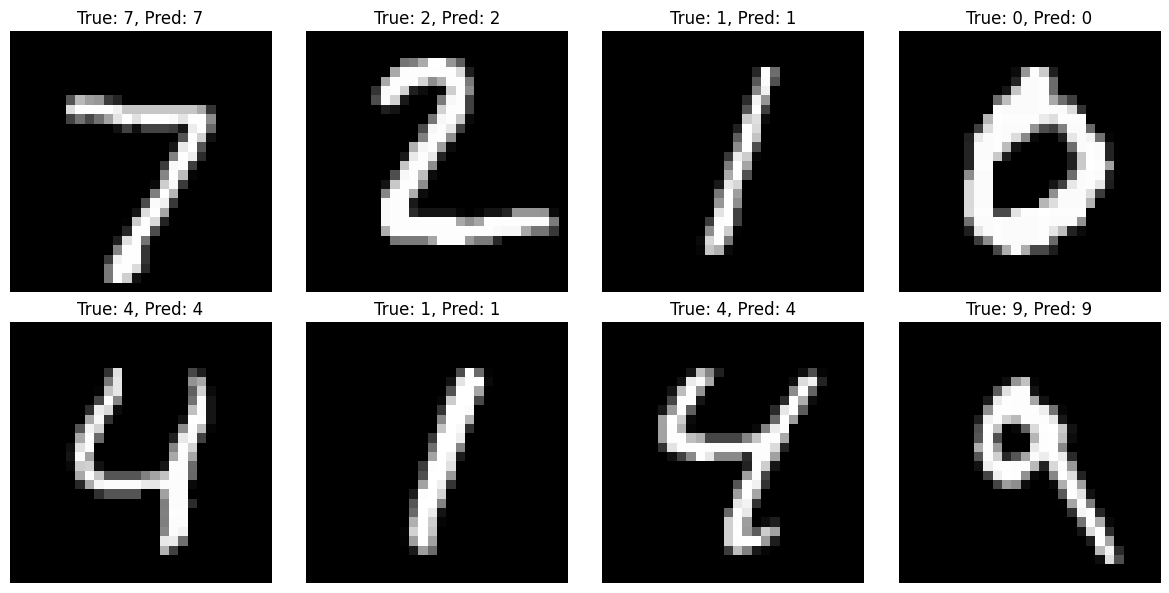

In [9]:
# Visualize some predictions
def visualize_predictions(model, test_loader, device, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        # Move back to CPU for visualization
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        img = images[0]

        img_np = img.squeeze().numpy()  # remove channel dimension

        print("Pixel values of the first image:")
        print(img_np)

        print(f"Min value: {img_np.min()}, Max value: {img_np.max()}")

        # Create subplot
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        axes = axes.ravel()
        
        for i in range(num_samples):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize predictions
print("Visualizing some predictions...")
visualize_predictions(model, test_loader, device)


## IPFE-enhanced CNN

In [43]:
# import ipfe functions
from altered_ipfe import IPFE
from joblib import Parallel, delayed

### current try

In the First layer we applied 16 filters of size 3x3, with input channel 1 (grayscale), so the total number of parameters is 16 * 3 * 3 * 1 = 144.

So With that each y is one filter flattened to a vector of length 9.
For an input x of size 28x28, flattened to a vector of length 784, we can compute the inner product <x, y> for each filter y.

Option 1 encrypt the entire input x of length 784, and padd the y to a length of 784 with zeros. -> This will be inefficient as the IPFE scheme will have to handle large vectors.

Option 2 encrypt patches of x corresponding to the filter size (3x3 = 9 elements), and compute the inner product for each patch with the filter y. This requires sliding the filter over the input image and encrypting each patch separately.

1. Step: Create patches of size 3x3 from the input image (28x28) -> This will create 28x28 patches (with padding). => 784 patches
2. Step: Encrypt each patch separately.
3. Step: Create 16 query vectors y (one for each filter), each of size 9 (3x3 flattened). => Create a Key for each vector
4. Step: decrypt each inner product result to get the convolution output.

In [54]:
class IPFECNN(nn.Module):
    def __init__(self, num_classes=10, prime=104729):
        super(IPFECNN, self).__init__()
        self.prime = prime
        self.ipfe = IPFE(prime)
        self.encryption_length = 9 # 3x3 filter size flattened

        self.ipfe.setup(self.encryption_length)
        print("IPFE setup done, with length:", self.encryption_length)

        # First convolutional block - this will be used with IPFE
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

        #copy weights from the trained model
        self.load_state_dict(model.state_dict())
        print("weights copied from trained model")

        self.weights = self.conv1.weight.data
        self.y_array = torch.round(self.weights.view(self.weights.size(0), -1).squeeze(1).view(self.weights.size(0), -1) * 10000).long().tolist()
        print("weights converted to y vectors")
        self.biases = self.conv1.bias
        print("biases saved")
        self.sk_y_array = [int(self.ipfe.key_derive(y)) for y in self.y_array]
        print("sk_ys created")
        # convert y to int here

    def forward(self, x, encrypted=False):
        # If y_vector is provided, use IPFE for first conv

        if encrypted:
            batch_size = x.shape[0]
            H, W = x.shape[2], x.shape[3]

            unfold = nn.Unfold(kernel_size=3, stride=1, padding=1)
            patches = unfold(x)
            num_patches = patches.shape[-1]
            num_kernels = len(self.sk_y_array)

            feature_maps_batch = []

            for b in range(batch_size):
                patches_b = patches[b].T
                decrypted_maps = torch.zeros(num_kernels, num_patches, device=x.device)

                # Loop over patches and kernels
                for p in range(num_patches):
                    patch = patches_b[p]
                    patch_int = [(int(val.item()) % (self.prime - 1)) for val in patch]

                    encrypted = self.ipfe.encrypt(patch_int)

                    for k in range(num_kernels):
                        decrypted_scaled = self.ipfe.decrypt(encrypted, self.sk_y_array[k], self.y_array[k])
                        decrypted = (decrypted_scaled / 10000) + self.biases[k].item() # bias needed W*X + B

                        decrypted_maps[k, p] = decrypted

                # Reshape to feature map: (num_kernels, H, W)
                feature_maps_b = decrypted_maps.view(num_kernels, H, W)
                feature_maps_batch.append(feature_maps_b)

            x_ipfe = torch.stack(feature_maps_batch, dim=0)  # (B, num_kernels, H, W)
            x_conv = self.conv1(x)

            b = 0

            diff = (x_conv - x_ipfe).abs()
            for c in range(num_kernels):
                H, W = x_conv.shape[2], x_conv.shape[3]
                h0, w0 = H // 2 - 2, W // 2 - 2  # top-left corner of 5x5 center
                h1, w1 = h0 + 5, w0 + 5          # bottom-right corner

                conv_center = x_conv[b, c, h0:h1, w0:w1].detach().cpu()
                ipfe_center = x_ipfe[b, c, h0:h1, w0:w1].detach().cpu()
                diff_center = diff[b, c, h0:h1, w0:w1].detach().cpu()

                print(f"\n=== Kernel {c} — Center 5×5 Region ===")
                print("Conv Output:\n", conv_center)
                print("IPFE Output:\n", ipfe_center)
                print("|Difference|:\n", diff_center)

            for c in range(num_kernels):
                plt.figure(figsize=(9, 3))

                # Conv Output
                plt.subplot(1, 3, 1)
                plt.imshow(x_conv[b, c].detach().cpu(), cmap="viridis")
                plt.title(f"Conv Output (Kernel {c})")
                plt.axis("off")

                # IPFE Output
                plt.subplot(1, 3, 2)
                plt.imshow(x_ipfe[b, c].detach().cpu(), cmap="viridis")
                plt.title(f"IPFE Output (Kernel {c})")
                plt.axis("off")

                # |Difference|
                plt.subplot(1, 3, 3)
                plt.imshow((x_conv[b, c] - x_ipfe[b, c]).abs().detach().cpu(), cmap="magma")
                plt.title("|Difference|")
                plt.axis("off")

                plt.tight_layout()
                plt.show()

            x = self.pool1(F.relu(self.bn1(x)))

        else:
            x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # use regular forward pass for remaining layers
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [55]:
# Initialize IPFE-enhanced CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ipfe_model = IPFECNN(num_classes=10, prime=104729).to(device)

print(f"IPFE-CNN model created on device: {device}")

IPFE setup done, with length: 9
weights copied from trained model
weights converted to y vectors
biases saved
sk_ys created
IPFE-CNN model created on device: cpu


Testing IPFE-CNN functionality...
Labels of test samples: [7 2 1 0 4]
Testing regular forward pass...
Regular predictions: [7 2 1 0 4]
Testing IPFE forward pass...

=== Kernel 0 — Center 5×5 Region ===
Conv Output:
 tensor([[   0.2044,    0.2044,    0.2044,    0.2044,  -27.1801],
        [   0.2044,    0.2044,    0.2044,  -11.7178,  -73.8316],
        [   0.2044,    0.2044,    0.2044,  -30.2039, -107.0529],
        [   0.2044,    0.2044,   -1.6142,  -49.1283, -139.9849],
        [   0.2044,    0.2044,  -25.7955,  -94.9997, -197.0984]])
IPFE Output:
 tensor([[ 0.2044,  0.2044,  0.2044,  0.2044,  4.2341],
        [ 0.2044,  0.2044,  0.2044, -1.2467, -0.5284],
        [ 0.2044,  0.2044,  0.2044,  1.2094, -2.3269],
        [ 0.2044,  0.2044, -1.6145,  3.2301, -3.8360],
        [ 0.2044,  0.2044, -4.8537, -0.7449,  1.8836]])
|Difference|:
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1414e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0471e+01, 7.3303e+01],
        [0.00

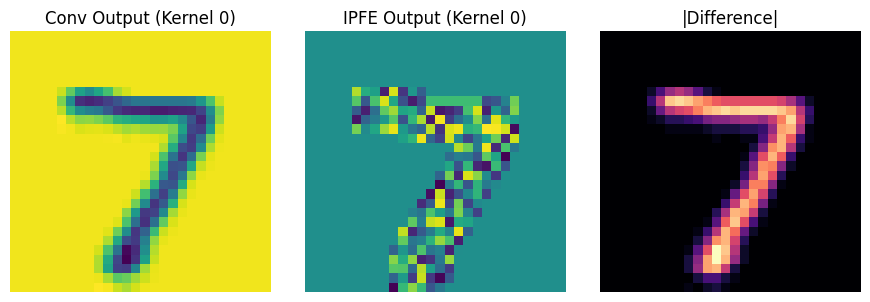

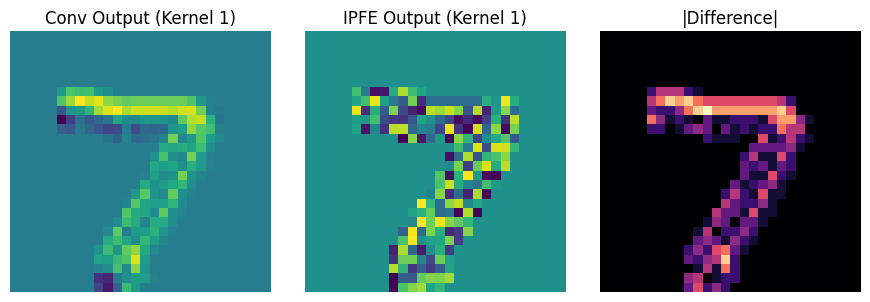

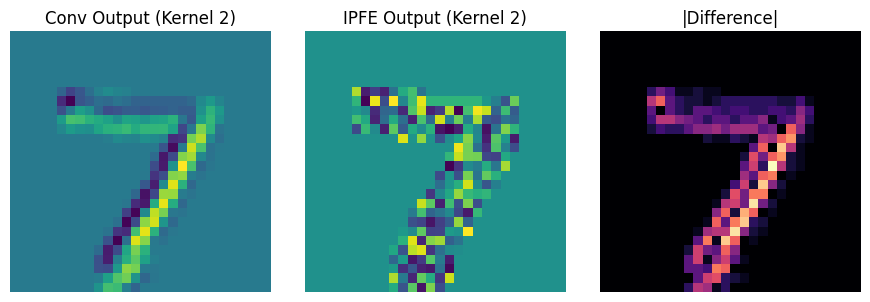

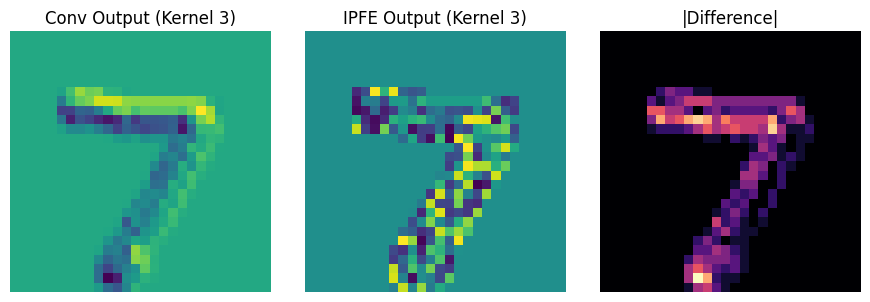

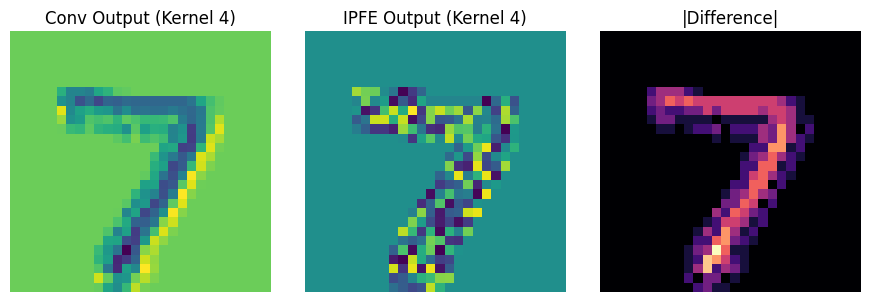

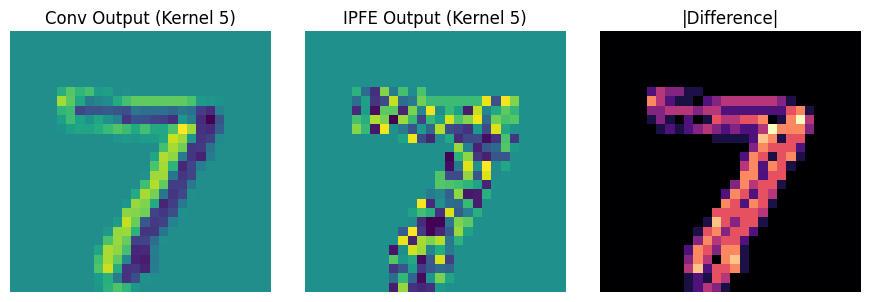

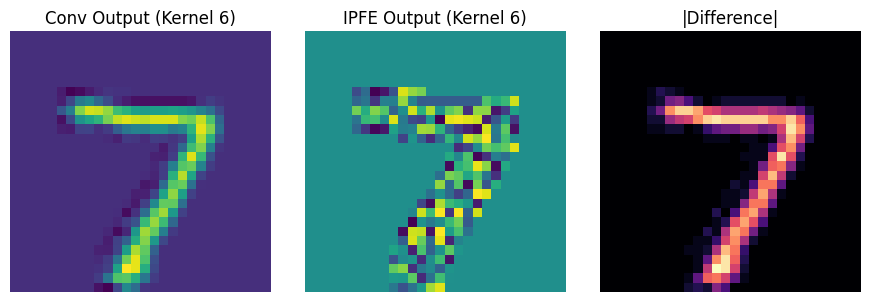

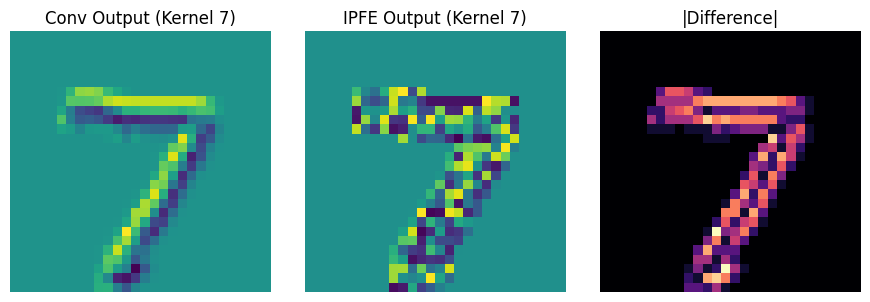

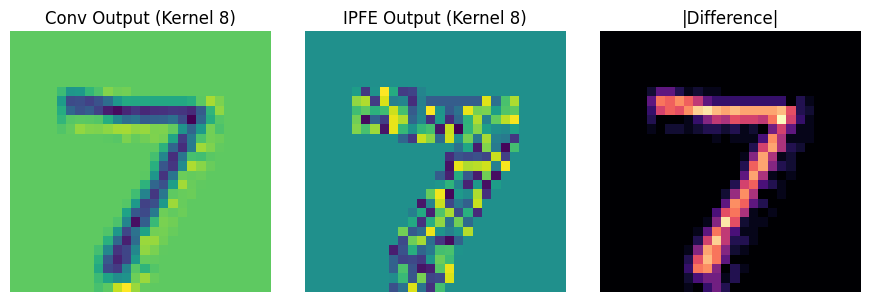

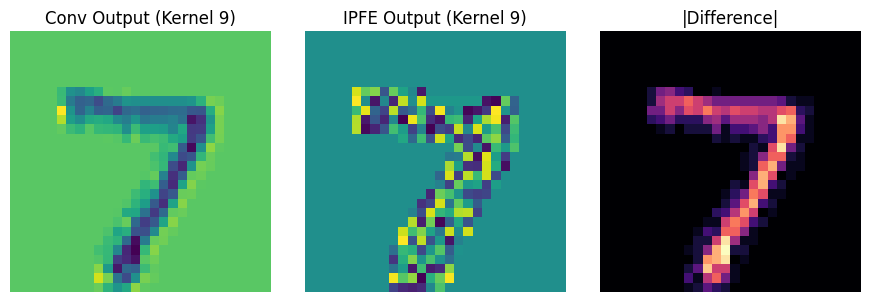

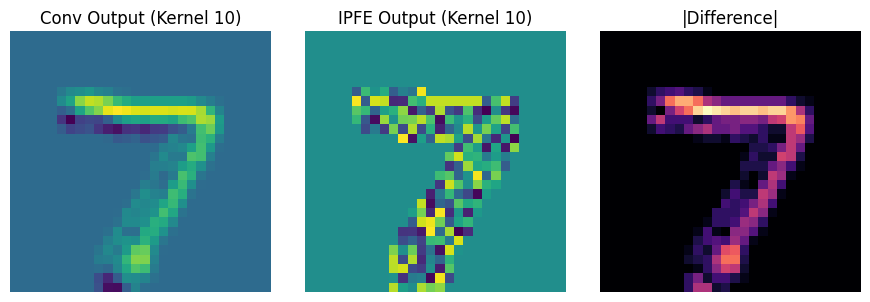

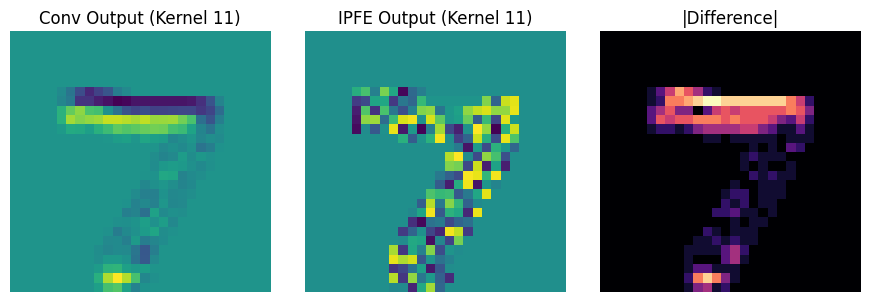

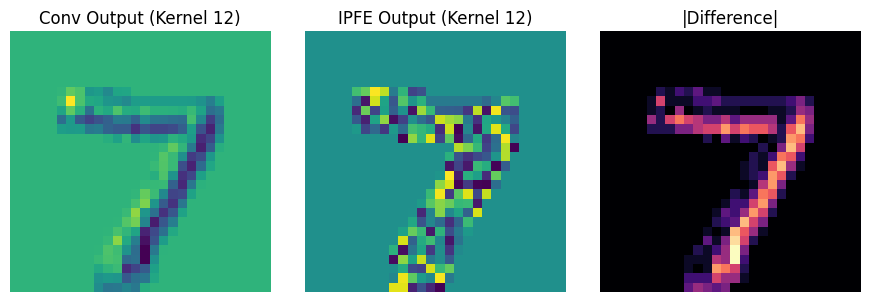

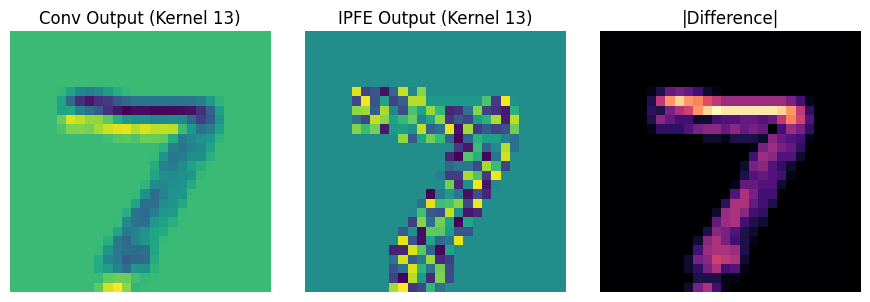

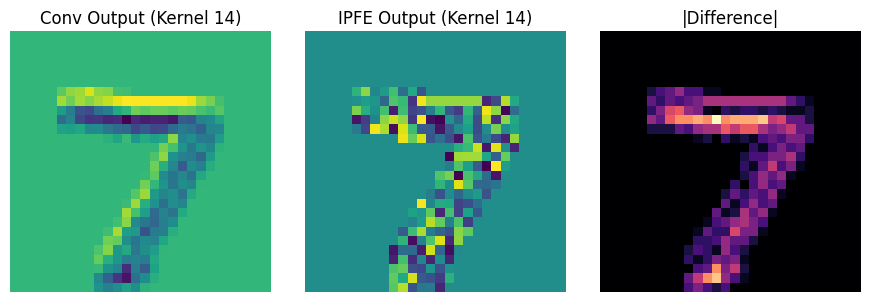

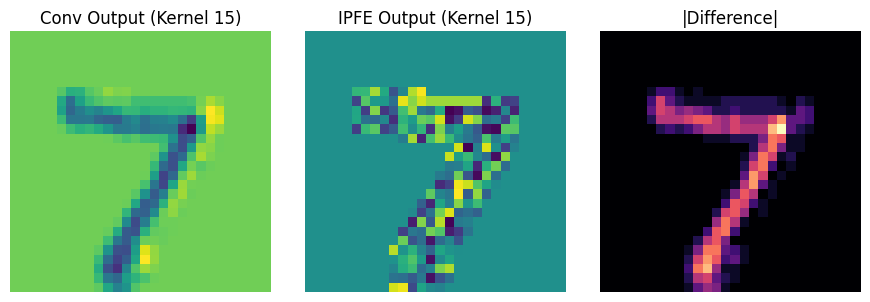

IPFE forward pass failed: running_mean should contain 1 elements not 16


In [56]:
# Test IPFE functionality with a sample
def test_ipfe_cnn(model, test_loader, device, num_samples=5):
    """Test the IPFE-CNN with a sample query vector"""
    model.eval()
    # x is 784 big

    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)
        print(f"Labels of test samples: {labels[:num_samples].cpu().numpy()}")

        # Test regular forward pass
        print("Testing regular forward pass...")
        regular_outputs = model(images[:num_samples])
        _, regular_predicted = regular_outputs.max(1)
        print("Regular predictions:", regular_predicted.cpu().numpy())

        # Test IPFE forward pass
        print("Testing IPFE forward pass...")
        try:
            ipfe_outputs = model.forward(images[:num_samples], encrypted=True)
            _, ipfe_predicted = ipfe_outputs.max(1)

            print(f"IPFE predictions: {ipfe_predicted.cpu().numpy()}")

            # Compare results
            matches = (regular_predicted == ipfe_predicted).sum().item()
            print(f"Prediction matches between regular and IPFE: {matches}/{num_samples}")

        except Exception as e:
            print(f"IPFE forward pass failed: {e}")

# Test the IPFE functionality
print("Testing IPFE-CNN functionality...")
test_ipfe_cnn(ipfe_model, test_loader, device)


### Old try

In [ ]:
# # Define IPFE-enhanced CNN with functional encryption
# class IPFECNN(nn.Module):
#     def __init__(self, num_classes=10, prime=104729):
#         super(IPFECNN, self).__init__()
#         self.prime = prime
#         self.ipfe = IPFE(prime)
#         self.input_size = None
#         self.ipfe.setup(28*28)
#         print("IPFE setup done")
#
#
#         # First convolutional block - this will be used with IPFE
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.pool1 = nn.MaxPool2d(2, 2)
#
#         # Second convolutional block
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.pool2 = nn.MaxPool2d(2, 2)
#
#         # Third convolutional block
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.pool3 = nn.MaxPool2d(2, 2)
#
#         # Fully connected layers
#         self.fc1 = nn.Linear(64 * 3 * 3, 128)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(128, num_classes)
#
#         # IPFE setup for first conv layer
#         self.ipfe_setup_done = False
#
#
#     def forward(self, x, y_vector=None):
#
#         # If y_vector is provided, use IPFE for first conv
#         if y_vector is not None:
#
#             if not self.ipfe_setup_done:
#                 self.setup_ipfe()
#
#             self.ipfe.key_derive(y_vector)
#             print(f"IPFE key derivation complete for provided query vector")
#
#             # Encrypt the input x (flattened)
#             x_flat = x.view(x.size(0), -1).cpu().numpy()
#
#             # For each sample in the batch, compute IPFE
#             ipfe_results = []
#             for x_i in x_flat:
#                 # Convert input to integers
#                 x_int = [int(val * 1000) % (self.prime - 1) for val in x_i]
#
#                 print("<x, y> (expected):", sum((xi * yi) for xi, yi in zip(x_int, y_vector)) % (self.prime - 1))
#
#                 # Encrypt input
#                 ct = self.ipfe.encrypt(x_int)
#
#                 # Decrypt to get inner product
#                 try:
#                     inner_product = self.ipfe.decrypt(ct)
#
#                     print("<x, y> (decrypted):", inner_product)
#
#                     ipfe_results.append(inner_product)
#                 except:
#                     print("IPFE decryption failed")
#                     # Fallback to regular computation if IPFE fails
#                     inner_product = sum(xi * yi for xi, yi in zip(x_int, y_vector)) % (self.prime - 1)
#                     ipfe_results.append(inner_product)
#
#             # Convert IPFE results back to tensor
#             ipfe_tensor = torch.tensor(ipfe_results, dtype=torch.float32).to(x.device)
#
#         # apply CNN normal
#
#         x = self.pool1(F.relu(self.bn1(self.conv1(x))))
#
#         # Continue with remaining layers
#         x = self.pool2(F.relu(self.bn2(self.conv2(x))))
#         x = self.pool3(F.relu(self.bn3(self.conv3(x))))
#
#         # Flatten and fully connected layers
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#
#         return x


### run IPFE-CNN

In [ ]:
# Initialize IPFE-enhanced CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ipfe_model = IPFECNN(num_classes=10, prime=104729).to(device)

# Copy weights from the trained model
ipfe_model.load_state_dict(model.state_dict())

ipfe_model.setup_ipfe()

print(f"IPFE-CNN model created on device: {device}")
print(f"Total parameters: {sum(p.numel() for p in ipfe_model.parameters()):,}")

In [ ]:
print(ipfe_model.conv1_length)

In [ ]:
# Test IPFE functionality with a sample
def test_ipfe_cnn(model, test_loader, device, num_samples=5):
    """Test the IPFE-CNN with a sample query vector"""
    model.eval()
    # x is 784 big

    # Create a sample query vector y (same length as flattened conv1 weights)
    y_vector = [1] * model.conv1_length  # Simple query vector of all 1s
    print("Using query vector y of length:", len(y_vector))
    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)
        print(f"Labels of test samples: {labels[:num_samples].cpu().numpy()}")

        # Test regular forward pass
        print("Testing regular forward pass...")
        regular_outputs = model(images[:num_samples])
        _, regular_predicted = regular_outputs.max(1)
        print("Regular predictions:", regular_predicted.cpu().numpy())

        # Test IPFE forward pass
        print("Testing IPFE forward pass...")
        try:
            ipfe_outputs = model.forward_with_ipfe(images[:num_samples], y_vector)
            _, ipfe_predicted = ipfe_outputs.max(1)

            print(f"Regular predictions: {regular_predicted.cpu().numpy()}")
            print(f"IPFE predictions: {ipfe_predicted.cpu().numpy()}")
            print(f"True labels: {labels[:num_samples].cpu().numpy()}")

            # Compare results
            matches = (regular_predicted == ipfe_predicted).sum().item()
            print(f"Prediction matches between regular and IPFE: {matches}/{num_samples}")

        except Exception as e:
            print(f"IPFE forward pass failed: {e}")

# Test the IPFE functionality
print("Testing IPFE-CNN functionality...")
test_ipfe_cnn(ipfe_model, test_loader, device)


In [ ]:
# Demonstrate IPFE with different query vectors
def demonstrate_ipfe_queries(model, test_loader, device):
    """Demonstrate IPFE with different query vectors"""
    model.eval()
    
    # Get a single test sample
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    single_image = images[0:1].to(device)  # Single sample
    true_label = labels[0].item()
    
    print(f"Testing with image of digit: {true_label}")
    
    # Different query vectors to test
    query_vectors = {
        "All ones": [1] * model.conv1_length,
        "All zeros": [0] * model.conv1_length,
        "Alternating": [1 if i % 2 == 0 else -1 for i in range(model.conv1_length)],
        "Random": [1, 0, 1, 0] * (model.conv1_length // 4) + [1] * (model.conv1_length % 4)
    }
    
    print("\nTesting different query vectors:")
    print("-" * 50)
    
    for name, y_vector in query_vectors.items():
        try:
            # Regular forward pass
            regular_output = model(single_image)
            regular_pred = regular_output.max(1)[1].item()
            
            # IPFE forward pass
            ipfe_output = model.forward_with_ipfe(single_image, y_vector)
            ipfe_pred = ipfe_output.max(1)[1].item()
            
            print(f"{name:15} - Regular: {regular_pred}, IPFE: {ipfe_pred}, Match: {regular_pred == ipfe_pred}")
            
        except Exception as e:
            print(f"{name:15} - IPFE failed: {str(e)[:50]}...")

# Demonstrate with different queries
print("Demonstrating IPFE with different query vectors...")
demonstrate_ipfe_queries(ipfe_model, test_loader, device)


In [ ]:
# Visualize the first CNN layer's filters (weights)
def visualize_first_cnn_layer(model):
    """Visualize the first convolutional layer filters"""
    # Find the first conv layer
    first_conv = None
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            first_conv = m
            break
    if first_conv is None:
        print("No Conv2d layer found in model.")
        return

    weights = first_conv.weight.data.cpu()
    num_filters = weights.shape[0]

    # Calculate grid size
    cols = 8
    rows = (num_filters + cols - 1) // cols

    plt.figure(figsize=(cols*1.5, rows*1.5))
    for i in range(num_filters):
        ax = plt.subplot(rows, cols, i+1)
        # For grayscale, show as [out_ch, in_ch, H, W]
        w = weights[i, 0].numpy()
        ax.imshow(w, cmap='gray')
        ax.axis('off')
        ax.set_title(f'F{i}')
    plt.tight_layout()
    plt.suptitle("First Conv Layer Filters (IPFE-enhanced)")
    plt.show()

print("Visualizing first CNN layer filters...")
visualize_first_cnn_layer(ipfe_model)
